In [322]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas
from scipy import special

Text(0.5, 1.0, 'Transmittance (scanning through temperature)')

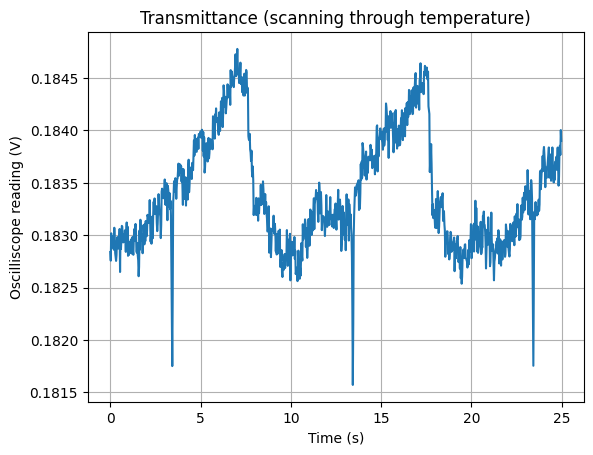

In [410]:
file_name = 'MokuOscilloscopeData_absorptions_notemp_20240712_184750_Traces'
path = ''
csvFile = pandas.read_csv(path + file_name + '.csv', skiprows=8)
data = csvFile.to_numpy()

time = data[:,0] # sec
time_shifted = time - time[0]
A = data[:,1].astype(np.float64) # power reading (V)
signal = data[:,2].astype(np.float64) # applied ramp signal (V)
plt.plot(time_shifted, A)
plt.xlabel('Time (s)')
plt.ylabel('Oscilliscope reading (V)')
#plt.legend(['A', 'B'])
idx_first_dip = np.where((time_shifted > 3) & (time_shifted < 3.8))[0]
idx_second_dip = np.where((time_shifted > 13.1) & (time_shifted < 13.8))[0]
idx_third_dip = np.where((time_shifted > 23) & (time_shifted < 23.8))[0]
plt.grid()
plt.title('Transmittance (scanning through temperature)')

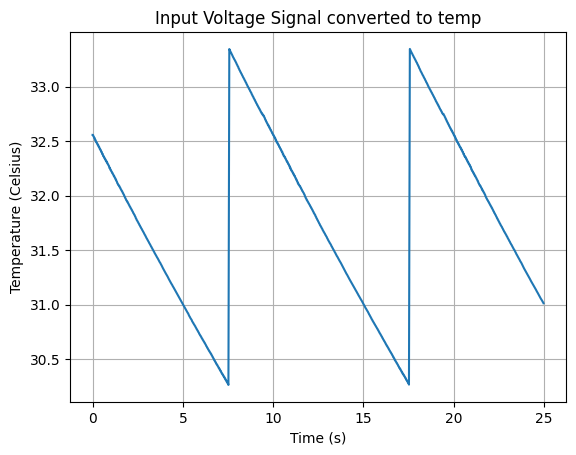

In [405]:
# This converts the time values to temperature (first converting to resistance from input signal, 
# then converting to temperature using the Steinhart Hart equation). This assumes that the 
# Steinhart-Hart equation is accurate (based on power measurements, close enough). 
# plt.plot(time_shifted, signal)
r0 = 6.996 # initial resistance set at before scanning (kOhms)
R = (r0 + signal*2)*1000 # V * kOhm/V = Ohm
A, B, C = 1.129241e-3, 2.341077e-4, 0.087755e-6 # Steinhart coefficients 
temp = 1/(A + B*np.log(R) + C*(np.log(R))**3) - 273.15 # in Celsius
plt.plot(time_shifted, temp)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (Celsius)') # assuming the specs work out
plt.title('Input Voltage Signal converted to temp')
plt.grid()

In [333]:
def get_temp_resonance(min_time): # linearly interpolate around the point of minimum transmittance to get temperature at the transition
    time_upper = time_shifted[np.where(time_shifted > min_time)]
    time_lower = time_shifted[np.where(time_shifted < min_time)]
    temp_upper = temp[np.where(time_shifted > min_time)]
    temp_lower = temp[np.where(time_shifted < min_time)]

    slope = (temp_upper[0] - temp_lower[-1])/(time_upper[0] - time_lower[-1])
    y_intercept = temp_upper[0] - slope*time_upper[0]
    return(y_intercept + slope * min_time)

In [398]:
def get_info(idx_dip, p0_gaussian, p0_lorentzian, p0_voigt):
    time_section, A_section = time_shifted[idx_dip.astype(int)], A[idx_dip.astype(int)]
    time_fit = np.linspace(time_section[0], time_section[-1], 1000)

    # Different profiles that could fit to the dip (I think Voigt makes the most sense because you likely have both types of broadening so
    # you should get a convolution of Gaussian + Lorentzian)
    def gaussian(x, H, A, x0, sigma):                       # sigma * sqrt(2 ln 2) = HWHM
        return H + (A*np.exp(-(x-x0)**2 / (2*sigma**2)))
    def lorentzian(x, H, A, x0, tau):                       # tau = HWHM
        return H - A * tau/((x-x0)**2 + (tau**2/4))
    def voigt(x, H, A, x0, alpha, gamma):                   # Lorentzian component HWHM = gamma and Gaussian component HWHM = alpha
        sigma = alpha / np.sqrt(2 * np.log(2))
        return H + A * np.real(special.wofz(((x-x0) + 1j*gamma) / sigma / np.sqrt(2))) / sigma / np.sqrt(2*np.pi)

    params, covariance = curve_fit(gaussian, time_section, A_section, p0=p0_gaussian, maxfev = 100000, bounds=([-np.inf, -np.inf, -np.inf, 0],
                                                                                                               [np.inf, np.inf, np.inf, np.inf])) 
    fit_gaussian = gaussian(time_fit.astype(np.float32), *params) 
    print('------------Gaussian-----------------')
    print('Location of minimum (s): ', params[2])
    print('Corresponding temperature (Celsius): ', get_temp_resonance(params[2]))
    print('Sigma: ', params[-1])
    print('FWHM Gaussian: ', 2*params[-1]*np.sqrt(2*np.log(2)))

    params, covariance = curve_fit(lorentzian, time_section, A_section, p0=p0_lorentzian, maxfev = 100000, bounds=([-np.inf, -np.inf, -np.inf, 0],
                                                                                                                   [np.inf, np.inf, np.inf, np.inf])) 
    fit_lorentzian = lorentzian(time_fit.astype(np.float32), *params) 
    print('------------Lorentzian-----------------')
    print('Location of minimum (s): ', params[2])
    print('Corresponding temperature (Celsius): ', get_temp_resonance(params[2]))
    print('Tau: ', params[0])
    print('FWHM Lorentzian: ', 2*params[-1])

    params, covariance = curve_fit(voigt, time_section, A_section, p0=p0_voigt, maxfev = 100000, bounds=([-np.inf, -np.inf, -np.inf, 0, 0],
                                                                                                         [np.inf, np.inf, np.inf, np.inf, np.inf]))
    fit_voigt = voigt(time_fit, *params) 
    print('------------Voigt-----------------')
    print('Location of minimum (s): ', params[2])
    print('Corresponding temperature (Celsius): ', get_temp_resonance(params[2]))
    print('Alpha (Gaussian): ', params[-2])
    print('Gamma (Lorentzian): ', params[-1])
    print('Location of minimum (s): ', params[2])
    print('FWHM Gaussian + FWHM Lorentzian = FWHM Voigt? = ', 2*params[-2], '+', 2*params[-1], '=', 2*params[-2]+2*params[-1])

    plt.plot(time_section, A_section, '-o', linewidth=2, markersize=3.5)
    plt.plot(time_fit, fit_lorentzian, ls='dashdot', alpha=0.8)
    plt.plot(time_fit, fit_gaussian, ls='dashed')
    plt.plot(time_fit, fit_voigt, ls='dashdot', alpha=0.7)
    plt.grid()
    plt.legend(['Data', 'Lorentzian Fit', 'Gaussian Fit', 'Voigt Fit'])
    plt.xlabel('Time (s)')
    plt.ylabel('Oscilliscope reading (V)')

------------Gaussian-----------------
Location of minimum (s):  3.42529333549888
Corresponding temperature (Celsius):  31.478195660258475
Sigma:  0.03002678183635686
FWHM Gaussian:  0.07070766775602436
------------Lorentzian-----------------
Location of minimum (s):  3.4260472876906474
Corresponding temperature (Celsius):  31.47788105291556
Tau:  0.18347870737082939
FWHM Lorentzian:  0.11850736499196148
------------Voigt-----------------
Location of minimum (s):  3.4257499354423895
Corresponding temperature (Celsius):  31.478005131340897
Alpha (Gaussian):  0.026752825418021816
Gamma (Lorentzian):  0.012377236127913357
Location of minimum (s):  3.4257499354423895
FWHM Gaussian + FWHM Lorentzian = FWHM Voigt? =  0.05350565083604363 + 0.024754472255826714 = 0.07826012309187035


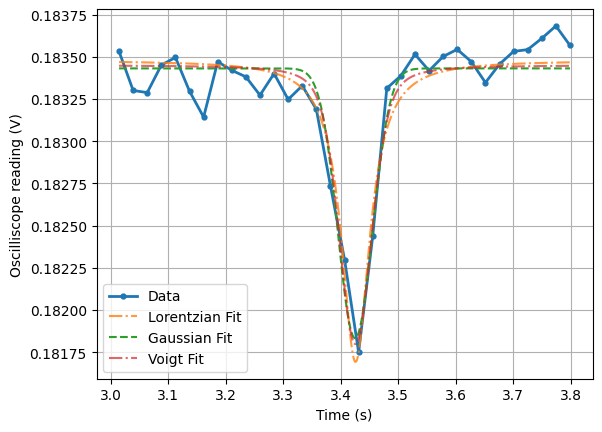

In [400]:
p0_gaussian_3 = [0.1835, 0.0001, 23.4, 0.01] # H, A, x0, sigma
p0_lorentz_3 = [0.1835, 0.0001, 23.4, 0.01] # H, A, x0, tau
p0_voigt_3 = [0.1835, -0.0003, 23.4, 0.01, 0.05] #  H, A, x0, alpha, gamma

p0_gaussian_2 = [0.1835, 0.0001, 13.4, 0.01] # H, A, x0, sigma
p0_lorentz_2 = [0.1835, 0.0001, 13.4, 0.01] # H, A, x0, tau
p0_voigt_2 = [0.1835, -0.0003, 13.4, 0.01, 0.05] #  H, A, x0, alpha, gamma

p0_gaussian_1 = [0.1835, 0.0001, 3.4, 0.01] # H, A, x0, sigma
p0_lorentz_1 = [0.1835, 0.0001, 3.4, 0.01] # H, A, x0, tau
p0_voigt_1 = [0.1835, -0.0003, 3.4, 0.01, 0.05] #  H, A, x0, alpha, gamma

get_info(idx_first_dip, p0_gaussian_1, p0_lorentz_1, p0_voigt_1)

------------Gaussian-----------------
Location of minimum (s):  13.431008553484263
Corresponding temperature (Celsius):  31.477621624243902
Sigma:  0.02912145938196571
FWHM Gaussian:  0.06857579629320745
------------Lorentzian-----------------
Location of minimum (s):  13.431054050439768
Corresponding temperature (Celsius):  31.477603232731283
Tau:  0.18334501970082678
FWHM Lorentzian:  0.11969804713936169
------------Voigt-----------------
Location of minimum (s):  13.43124268195803
Corresponding temperature (Celsius):  31.477526981058833
Alpha (Gaussian):  0.015325847317183727
Gamma (Lorentzian):  0.022935838973460028
Location of minimum (s):  13.43124268195803
FWHM Gaussian + FWHM Lorentzian = FWHM Voigt? =  0.030651694634367455 + 0.045871677946920056 = 0.07652337258128751


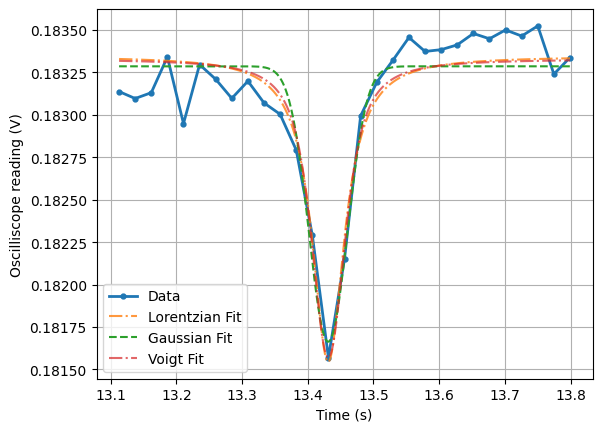

In [401]:
get_info(idx_second_dip, p0_gaussian_2, p0_lorentz_2, p0_voigt_2)

------------Gaussian-----------------
Location of minimum (s):  23.42697968099341
Corresponding temperature (Celsius):  31.481260638101094
Sigma:  0.025815032467998763
FWHM Gaussian:  0.060789755918768264
------------Lorentzian-----------------
Location of minimum (s):  23.427397532882182
Corresponding temperature (Celsius):  31.481114625371518
Tau:  0.18338134858603639
FWHM Lorentzian:  0.09987252886903303
------------Voigt-----------------
Location of minimum (s):  23.42775388163628
Corresponding temperature (Celsius):  31.480990104086185
Alpha (Gaussian):  0.018692919131845773
Gamma (Lorentzian):  0.01458484057967065
Location of minimum (s):  23.42775388163628
FWHM Gaussian + FWHM Lorentzian = FWHM Voigt? =  0.037385838263691545 + 0.0291696811593413 = 0.06655551942303284


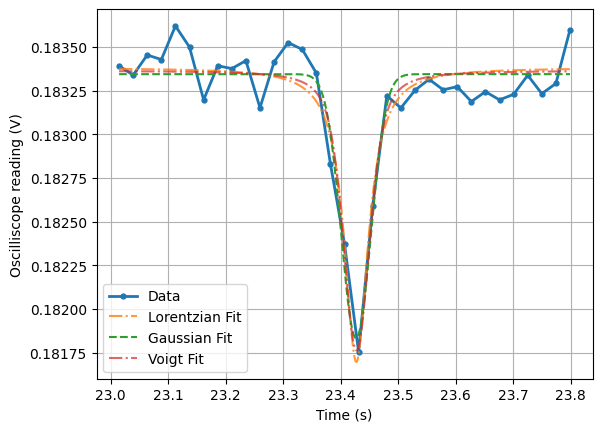

In [402]:
get_info(idx_third_dip, p0_gaussian_3, p0_lorentz_3, p0_voigt_3)

In [404]:
t_3 = np.array([31.478195660258475, 31.47788105291556, 31.478005131340897])  # Gaussian, Lorentzian, Voigt
t_2= np.array([31.477621624243902, 31.477603232731283, 31.477526981058833])  # Gaussian, Lorentzian, Voigt
t_1 = np.array([31.481260638101094, 31.481114625371518, 31.480990104086185]) # Gaussian, Lorentzian, Voigt

gaussian_t = [t_1[0], t_2[0], t_3[0]]
lorentzian_t = [t_1[1], t_2[1], t_3[1]]
voigt_t = [t_1[2], t_2[2], t_3[2]]

print('First dip avg (Celsius): ', np.average(t_1), np.std(t_1))
print('Second dip avg: ', np.average(t_2), np.std(t_2))
print('Third dip avg: ', np.average(t_3), np.std(t_3))

print('\nGaussian temp avg: ', np.average(gaussian_t), np.std(gaussian_t))
print('Lorentzian temp avg: ', np.average(lorentzian_t), np.std(lorentzian_t))
print('Voigt temp avg: ', np.average(voigt_t), np.std(voigt_t))

#print(np.average(np.array([np.average(t_1), np.average(t_2), np.average(t_3)])))
#print(np.std([np.average(t_1), np.average(t_2), np.average(t_3)]))


First dip avg (Celsius):  31.481121789186265 0.00011056115498379556
Second dip avg:  31.47758394601134 4.097410804092046e-05
Third dip avg:  31.47802728150498 0.00012938937973058917

Gaussian temp avg:  31.47902597420116 0.001597429475912055
Lorentzian temp avg:  31.47886630367279 0.0015938441704332132
Voigt temp avg:  31.478840738828637 0.001532315281052633


In [386]:
from sympy import Symbol, solve, log

# Convert from temperature to resistance using Steinhart-Hart equation
R = Symbol("R")
A = 1.129241e-3
B = 2.341077e-4
C = 0.087755e-6
T = 31.48 # Celsius

equation = 1/(A + B*log(R) + C*(log(R))**3) - 273.15 - T
solution = solve(equation, R)
print('Resistance (kOhms): ', solution[0] / 1000)

Resistance (kOhms):  7.56580894847710


# Alternatively
You can plot plt.plot(temp[idx_first_dip], A[idx_first_dip]) which converts time axis into the corresponding temperature. That is probably more useful than time now that I think about it. 

In [497]:
def get_info_temp(idx_dip, p0_gaussian, p0_lorentzian, p0_voigt):
    temp_section, A_section = temp[idx_dip.astype(int)], A[idx_dip.astype(int)]
    temp_fit = np.linspace(temp_section[0], temp_section[-1], 1000)

    # Different profiles that could fit to the dip (I think Voigt makes the most sense because you likely have both types of broadening so
    # you should get a convolution of Gaussian + Lorentzian)
    def gaussian(x, H, A, x0, sigma):                       # sigma * sqrt(2 ln 2) = HWHM
        return H + (A*np.exp(-(x-x0)**2 / (2*sigma**2)))
    def lorentzian(x, H, A, x0, tau):                       # tau = HWHM
        return H + A * tau/((x-x0)**2 + (tau**2/4))
    def voigt(x, H, A, x0, alpha, gamma):                   # Lorentzian component HWHM = gamma and Gaussian component HWHM = alpha
        sigma = alpha / np.sqrt(2 * np.log(2))
        return H + A * np.real(special.wofz(((x-x0) + 1j*gamma) / sigma / np.sqrt(2))) / sigma / np.sqrt(2*np.pi)

    params, covariance = curve_fit(gaussian, temp_section, A_section, p0=p0_gaussian, maxfev = 100000, bounds=([-np.inf, -np.inf, -np.inf, 0],
                                                                                                               [np.inf, np.inf, np.inf, np.inf])) 
    fit_gaussian = gaussian(temp_fit, *params) 
    print('------------Gaussian-----------------')
    print('"Resonant" Temperature (Celsius): ', params[2])
    print('Sigma: ', params[-1])
    print('FWHM Gaussian: ', 2*params[-1]*np.sqrt(2*np.log(2)))
    #print(params)

    params, covariance = curve_fit(lorentzian, temp_section, A_section, p0=p0_lorentzian, maxfev = 100000, bounds=([-np.inf, -np.inf, -np.inf, 0],
                                                                                                                   [np.inf, np.inf, np.inf, np.inf])) 
    fit_lorentzian = lorentzian(temp_fit, *params) 
    print('------------Lorentzian-----------------')
    print('"Resonant" Temperature (Celsius): ', params[2])
    print('Tau: ', params[0])
    print('FWHM Lorentzian: ', 2*params[-1])
    #print(params)

    params, covariance = curve_fit(voigt, temp_section, A_section, p0=p0_voigt, maxfev = 100000, bounds=([-np.inf, -np.inf, -np.inf, 0, 0],
                                                                                                         [np.inf, np.inf, np.inf, np.inf, np.inf]))
    fit_voigt = voigt(temp_fit, *params) 
    print('------------Voigt-----------------')
    print('"Resonant" Temperature (Celsius): ', params[2])
    print('Alpha (Gaussian): ', params[-2])
    print('Gamma (Lorentzian): ', params[-1])
    print('FWHM Gaussian + FWHM Lorentzian = FWHM Voigt? = ', 2*params[-2], '+', 2*params[-1], '=', 2*params[-2]+2*params[-1])
    #print(params)

    plt.plot(temp_section, A_section, '-o', linewidth=2, markersize=3.5)
    plt.plot(temp_fit, fit_lorentzian, ls='dashdot', alpha=0.8)
    plt.plot(temp_fit, fit_gaussian, ls='dashed')
    plt.plot(temp_fit, fit_voigt, ls='dashdot', alpha=0.7)
    plt.grid()
    plt.legend(['Data', 'Lorentzian Fit', 'Gaussian Fit', 'Voigt Fit'])
    plt.xlabel('Temperature (Celsius)')
    plt.ylabel('Oscilliscope reading (V)')

31.480623624117072
------------Gaussian-----------------
"Resonant" Temperature (Celsius):  31.481743475238872
Sigma:  0.008095645759285511
FWHM Gaussian:  0.01906378891143532
------------Lorentzian-----------------
"Resonant" Temperature (Celsius):  31.48168791753361
Tau:  0.18338147695296567
FWHM Lorentzian:  0.03058411143082088
------------Voigt-----------------
"Resonant" Temperature (Celsius):  31.48158053720516
Alpha (Gaussian):  0.005248580724079681
Gamma (Lorentzian):  0.005067860756226336
FWHM Gaussian + FWHM Lorentzian = FWHM Voigt? =  0.010497161448159362 + 0.010135721512452673 = 0.020632882960612033


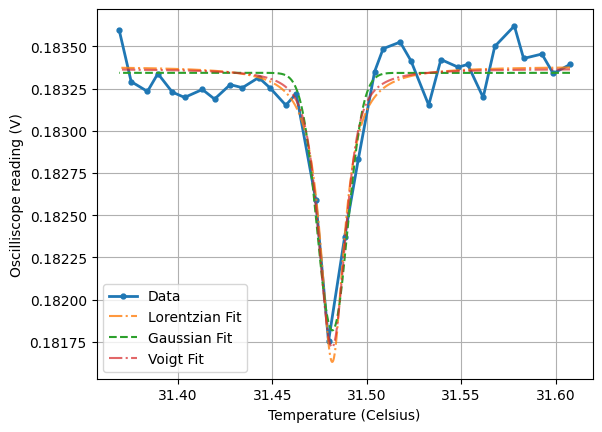

In [498]:
A_sect = A[idx_third_dip] 
min_idx = np.where(A_sect == np.min(A_sect))[0][0]
min_t = (time_shifted[idx_third_dip])[min_idx]
print(get_temp_resonance(min_t)) 
# for constraining the amount the curves are shifted 
# (getting the temperature at which you get minimum transmittance 
# and setting that as an initial guess)

p0_gaussian_3 = [0.1835, -0.0001, get_temp_resonance(min_t), 0.05] # H, A, x0, sigma
p0_lorentz_3 = [0.1835, -0.0001, get_temp_resonance(min_t), 0.05] # H, A, x0, tau
p0_voigt_3 = [0.1835, -0.0003, get_temp_resonance(min_t), 0.01, 0.05] #  H, A, x0, alpha, gamma

get_info_temp(idx_third_dip, p0_gaussian_3, p0_lorentz_3, p0_voigt_3)

31.479859760251742
------------Gaussian-----------------
"Resonant" Temperature (Celsius):  31.47924928562058
Sigma:  0.009383170145825862
FWHM Gaussian:  0.022095677145326714
------------Lorentzian-----------------
"Resonant" Temperature (Celsius):  31.479676130300977
Tau:  0.18334524697232302
FWHM Lorentzian:  0.035670571561389745
------------Voigt-----------------
"Resonant" Temperature (Celsius):  31.479632366276103
Alpha (Gaussian):  0.0030392239703429377
Gamma (Lorentzian):  0.008083718344600904
FWHM Gaussian + FWHM Lorentzian = FWHM Voigt? =  0.006078447940685875 + 0.016167436689201807 = 0.022245884629887684


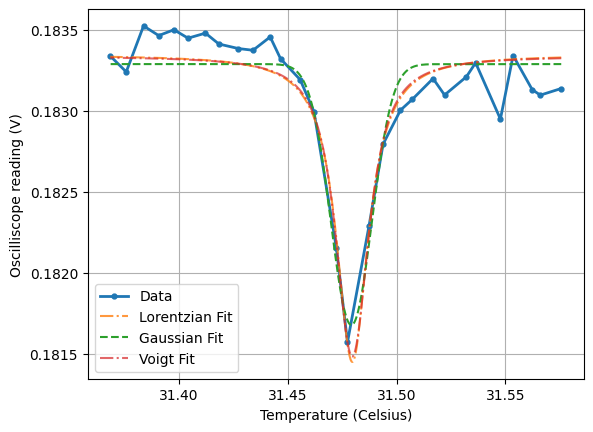

In [499]:
A_sect = A[idx_second_dip] 
min_idx = np.where(A_sect == np.min(A_sect))[0][0]
min_t = (time_shifted[idx_second_dip])[min_idx]
print(get_temp_resonance(min_t))

p0_gaussian_2 = [0.1835, -0.0001, get_temp_resonance(min_t), 0.05] # H, A, x0, sigma
p0_lorentz_2 = [0.1835, 6.69277538e-06, get_temp_resonance(min_t), 0.01] # H, A, x0, tau
p0_voigt_2 = [0.1835, -0.0003, get_temp_resonance(min_t), 0.01, 0.05] #  H, A, x0, alpha, gamma

get_info_temp(idx_second_dip, p0_gaussian_2, p0_lorentz_2, p0_voigt_2)

31.47801415160106
------------Gaussian-----------------
"Resonant" Temperature (Celsius):  31.479010946726174
Sigma:  0.008617978539309571
FWHM Gaussian:  0.02029378861201272
------------Lorentzian-----------------
"Resonant" Temperature (Celsius):  31.479205929051776
Tau:  0.1834769974563779
FWHM Lorentzian:  0.03223282160306811
------------Voigt-----------------
"Resonant" Temperature (Celsius):  31.479032203328757
Alpha (Gaussian):  0.007145751155330578
Gamma (Lorentzian):  0.00408313371390741
FWHM Gaussian + FWHM Lorentzian = FWHM Voigt? =  0.014291502310661156 + 0.00816626742781482 = 0.022457769738475977


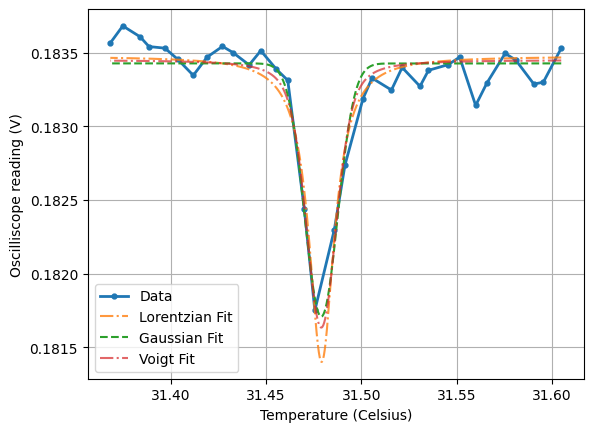

In [500]:
A_sect = A[idx_first_dip] 
min_idx = np.where(A_sect == np.min(A_sect))[0][0]
min_t = (time_shifted[idx_first_dip])[min_idx]
print(get_temp_resonance(min_t))
p0_gaussian_1 = [ 1.83288181e-01, -1.61196452e-03,  get_temp_resonance(min_t),  9.38406770e-03] # H, A, x0, sigma
p0_lorentz_1 = [1.83345245e-01, 8.45813332e-06, get_temp_resonance(min_t), 1.78350101e-02] # H, A, x0, tau
p0_voigt_1 = [ 1.83338631e-01, -5.12739531e-05, get_temp_resonance(min_t), 3.03968960e-03, 8.08310806e-03] #  H, A, x0, alpha, gamma

get_info_temp(idx_first_dip, p0_gaussian_1, p0_lorentz_1, p0_voigt_1)

Voigt Profile:

$V(x;\sigma;\gamma)=\frac{Re[w(z)]}{\sigma\sqrt{2\pi}}$ where $z=\frac{x+i\gamma}{\sigma\sqrt{2}}$

Lorentzian component HWHM: $\gamma$

Gaussian component HWHM: $\alpha$ where $\alpha = \sigma\sqrt{2ln2}$ ($\sigma$ is the standard deviation of the Gaussian profile)

https://scipython.com/book/chapter-8-scipy/examples/the-voigt-profile/

https://stackoverflow.com/questions/59049433/fitting-voigt-function-to-data-in-python

https://lmfit.github.io/lmfit-py/builtin_models.html#example-1-fit-peak-data-to-gaussian-lorentzian-and-voigt-profiles

http://emilygraceripka.com/blog/16